Copyright (C) 2024  Adam Jones  All Rights Reserved

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import figure_standard
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [2]:
n_boot = 10001
figure_standard.standardize_plot_settings()
main_palette = figure_standard.create_main_palette()

In [3]:
df = pd.read_excel("../2_intermediate_data/main_model_data.xlsx")

In [4]:
studies = ['CCSHS', 'CFS', 'CHAT', 'MESA', 'WSC']

In [5]:
df.loc[df['study']=='ccshs', 'study'] = 'CCSHS'
df.loc[df['study']=='cfs', 'study'] = 'CFS'
df.loc[df['study']=='chat', 'study'] = 'CHAT'
df.loc[df['study']=='mesa', 'study'] = 'MESA'
df.loc[df['study']=='wsc', 'study'] = 'WSC'

In [6]:
df['decade_str'] = ''
for i, l in enumerate(reversed(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'])):
    df.loc[df['decade']==(i + 1), 'decade_str'] = l

In [7]:
df = df.sort_values(by=['decade_str', 'study'], ascending=[True, True])
df['weight'] = 1

In [8]:
# add some fake rows so that the studies are ordered correctly (weight=0)
df_fake = pd.DataFrame(columns=df.keys())

for i, study in enumerate(studies):
    df_fake.loc[i, 'study'] = study
    df_fake.loc[i, 'decade'] = df[df.study == study].decade_str.unique()[0]
    df_fake.loc[i, 'weight'] = 0

df_full = pd.concat([df_fake, df], axis=0)

In [9]:
### c
df_stages = df[['w_per_spt','n1_per_spt','n2_per_spt','n3_per_spt','rem_per_spt']].copy()
df_stages = df_stages.rename(columns={"w_per_spt": "Wake","n1_per_spt": "N1","n2_per_spt": "N2","n3_per_spt": "N3","rem_per_spt": "REM"})

df_stages = 100 *df_stages

In [10]:
### d
df_all = pd.read_excel('../2_intermediate_data/all_recordings_by_epoch.xlsx')
df_all['rec_count'] = df_all['rec_count']/4000
data_per = pd.melt(df_all, id_vars=['epoch_i'], value_vars=(['wake_per', 'n1_per', 'n2_per', 'n3_per', 'rem_per', 'rec_count']))
data_per['value'] = 100 *data_per['value']
# make a copy of the epoch_i
data_per['epoch_i_org'] = data_per['epoch_i']
# in (X) 30-sec epochs
epoch_bin_size = 30

# relabel the epoch_i to get stats on each
data_per['epoch_i'] = data_per['epoch_i_org'].apply(lambda x: int(x/epoch_bin_size))

data_per['time_hr'] = ((data_per['epoch_i'] + 1)*epoch_bin_size - epoch_bin_size/2) * (30/3600)

In [11]:
### e
df_per = pd.melt(df, id_vars=['decade'], value_vars=(['w_per_spt','n1_per_spt','n2_per_spt','n3_per_spt','rem_per_spt']))

df_per['value'] = 100*df_per['value']

In [12]:
### f
df_census = pd.read_excel("../2_intermediate_data/census.xlsx")
set_names = ["training", "validation", "testing"]

set_decade_counts = df.groupby(['set', 'decade'])['id'].count().unstack(fill_value=0).to_numpy(dtype=float)
decade_counts = set_decade_counts.sum(0)/set_decade_counts.sum()

# create a dataframe for age
df_age = pd.DataFrame(columns=["decade", "percent"])

for decade in range(10):
    df_age.loc[len(df_age)] = [(decade+1), 100*decade_counts[decade]]
df_age['decade'] = df_age['decade'].astype(int)

set_decade_counts_male = df[df.male==1].groupby(['set', 'decade'])['id'].count().unstack(fill_value=0).to_numpy(dtype=float)
decade_counts_male = set_decade_counts_male.sum(0)/set_decade_counts.sum(0)

# create a dataframe for sex
df_sex = pd.DataFrame(columns=["decade", "percent"])

for decade in range(10):
    df_sex.loc[len(df_sex)] = [(decade+1), 100*decade_counts_male[decade]]
df_sex['decade'] = df_sex['decade'].astype(int)

df_census['dummy'] = 1
df_sex['dummy'] = 1
df_age['dummy'] = 1

In [13]:
sws_per = pd.read_excel("../2_intermediate_data/sws_danker.xlsx")

In [14]:
### b
df_n3_pred = pd.read_excel('../2_intermediate_data/model_n3_by_epoch.xlsx')
# scale to total
for stage in ['Wake', 'N1', 'N2', 'N3', 'REM']:
    df_n3_pred[stage] = df_n3_pred[stage] / df_n3_pred['Total']

# scale to total
df_n3_pred['Total'] = df_n3_pred['Total'] / df_n3_pred['Total'].max()
data_n3 = pd.melt(df_n3_pred, id_vars=['epoch_i'], value_vars=(['Wake', 'N1', 'N2', 'N3', 'REM', 'Total']))
epoch_bin_width = 60

data_n3['epoch_bin'] = data_n3['epoch_i'] // epoch_bin_width
data_n3['time_hr'] = (data_n3['epoch_bin'] + 0.5) * epoch_bin_width * 30 / 3600

data_n3['value'] = 100 * data_n3['value']

# adjustment to scale up total
data_n3.loc[data_n3.variable == 'Total', 'value'] = data_n3.loc[data_n3.variable == 'Total', 'value'] * 1.1

In [15]:
df_per = pd.melt(df, id_vars=['decade','study'], value_vars=(['n3_per_spt']))

df_per['value'] = 100*df_per['value']

In [16]:
df_per_pred = pd.melt(df, id_vars=['decade','study'], value_vars=(['n3_per_spt_pred']))

df_per_pred['value'] = 100*df_per_pred['value']


ccshs_width = 0.5

ccshs_before = df_per_pred[df_per_pred['study']=='CCSHS'].__deepcopy__()
ccshs_before['decade'] = 2-ccshs_width/2
df_per_pred.loc[df_per_pred['study']=='CCSHS', 'decade'] = 2+ccshs_width/2
df_per_pred_ccshs_fix = pd.concat([df_per_pred, ccshs_before], ignore_index=True)



In [17]:
# test set only
df_per2 = pd.melt(df[df['set']==3], id_vars=['decade','study'], value_vars=(['n3_per_spt']))

df_per2['value'] = 100*df_per2['value']

df_per =df_per2

In [18]:

ccshs_before = df_per[df_per['study']=='CCSHS'].__deepcopy__()
ccshs_before['decade'] = 2-ccshs_width/2
df_per.loc[df_per['study']=='CCSHS', 'decade'] = 2+ccshs_width/2
df_per_ccshs_fix = pd.concat([df_per, ccshs_before], ignore_index=True)

In [19]:
df_n3_kappa = pd.melt(df[df['set']==3], id_vars=['decade','study'], value_vars=(['n3_kappa']))

ccshs_before = df_n3_kappa[df_n3_kappa['study']=='CCSHS'].__deepcopy__()
ccshs_before['decade'] = 2-ccshs_width/2
df_n3_kappa.loc[df_n3_kappa['study']=='CCSHS', 'decade'] = 2+ccshs_width/2
df_n3_kappa_ccshs_fix = pd.concat([df_n3_kappa, ccshs_before], ignore_index=True)

1 extra bytes in post.stringData array
fdsc NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
just NOT subset; don't know how to subset; dropped


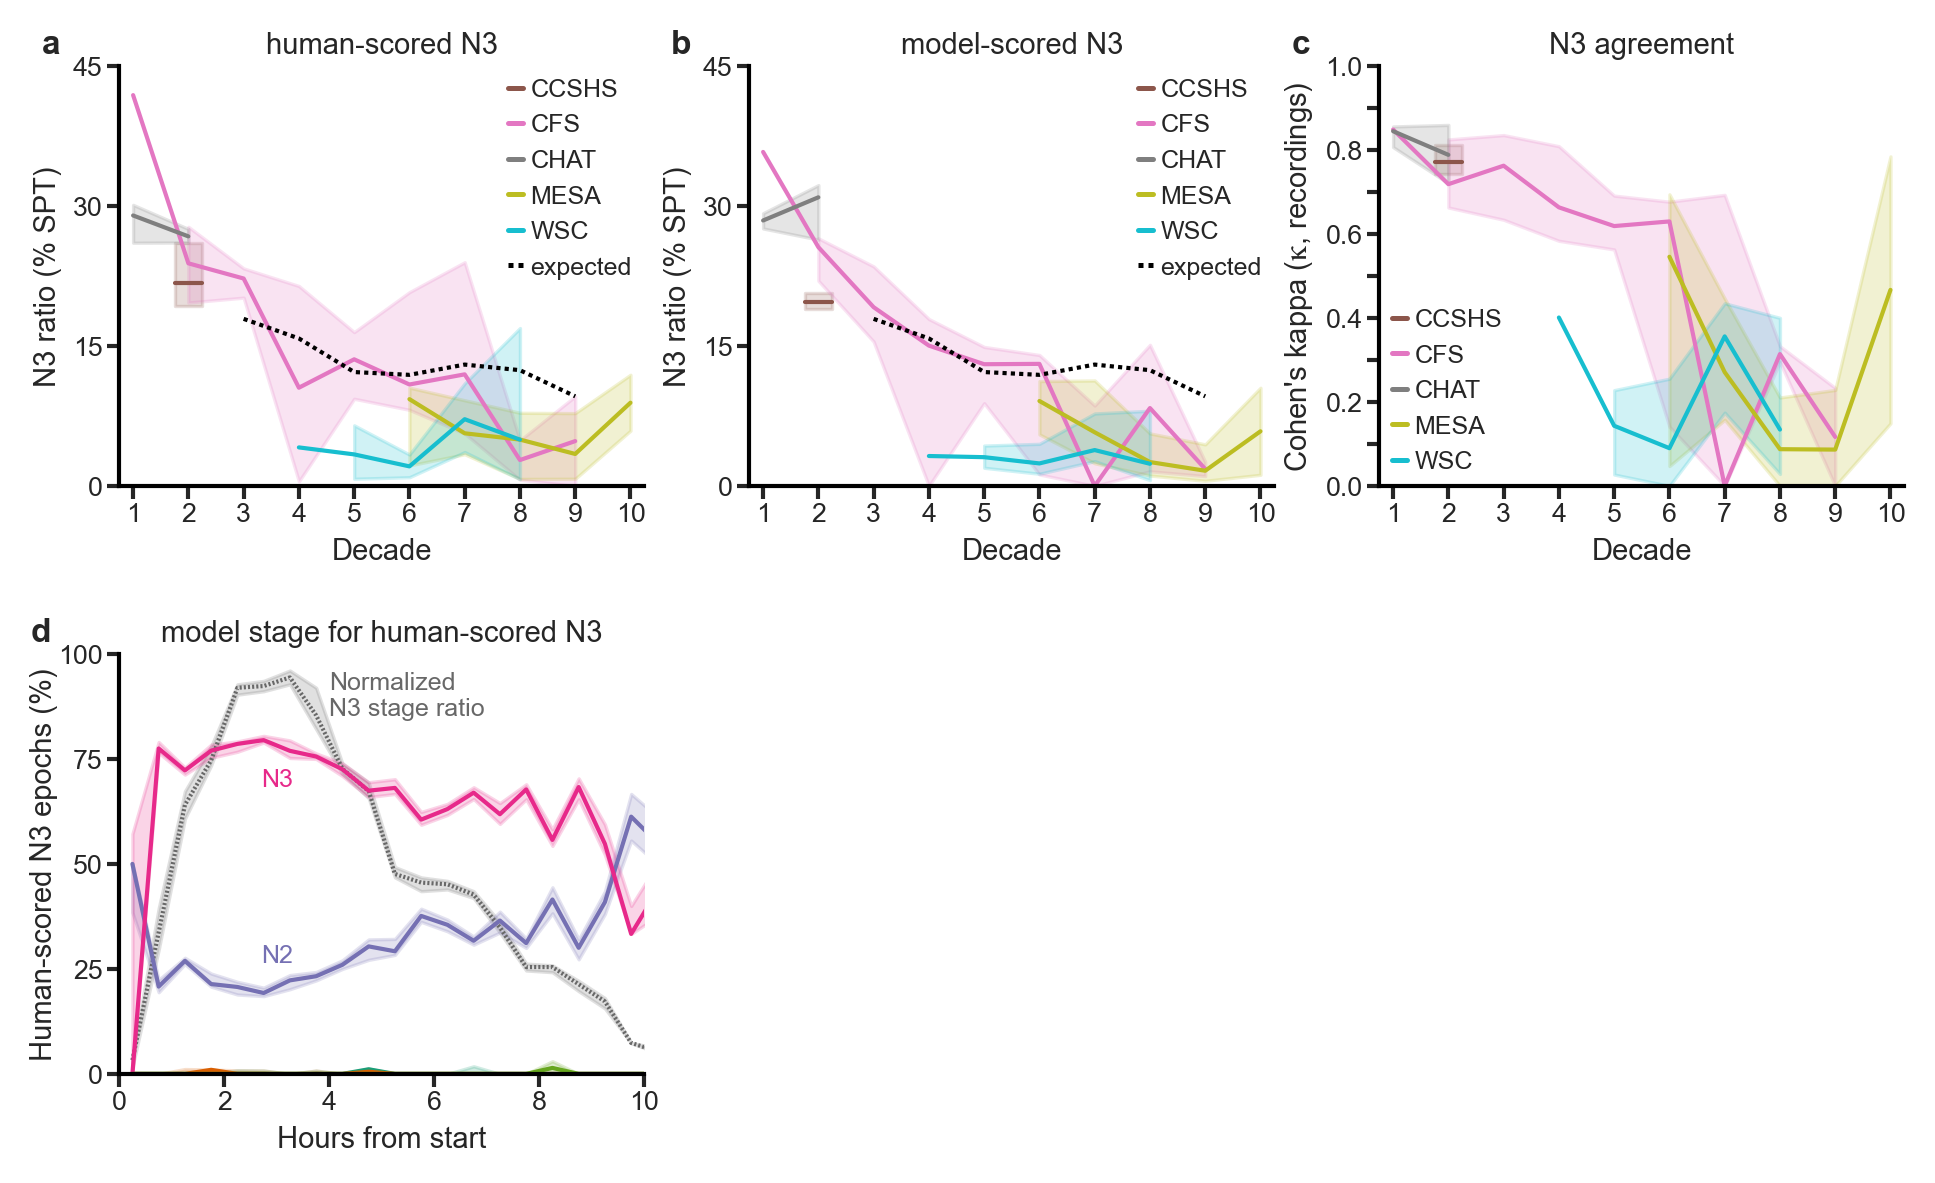

In [20]:
gs = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])

ax4 = plt.subplot(gs[1, 0])

study_palette = sns.color_palette("tab10", 10, desat=1)[5:]

### a
for i, study in enumerate(studies):
    sns.lineplot(
        data=df_per_ccshs_fix[df_per_ccshs_fix["study"] == study],
        x="decade",
        y="value",
        linewidth=1,
        palette=[study_palette[i]],
        n_boot=n_boot,
        estimator="median",
        clip_on=False,
        ax=ax1,
        hue="study",
    )

sws_per["dummy"] = "expected"
sns.lineplot(
    data=sws_per,
    x="decade",
    y="n3_per",
    linewidth=1,
    # hue='black',
    palette=[(0, 0, 0)],
    # linecolor='black',
    n_boot=n_boot,
    estimator="median",
    clip_on=False,
    ax=ax1,
    hue="dummy",
    style="dummy",
    dashes=[(1, 1)],
)

ax1.set_ylim([0, 45])
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

ax1.set_xlim([0.75, 10.25])
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

sns.despine(ax=ax1, right=True, top=True, bottom=False)
ax1.grid(False)
ax1.tick_params(axis="y", left=True, width=1, length=3, pad=1)
ax1.tick_params(axis="x", bottom=True, width=1, length=3, pad=1)

labelpad = 2.5
ax1.set_ylabel("N3 ratio (% SPT)", fontweight=None, labelpad=labelpad)
ax1.set_xlabel("Decade", fontweight=None, labelpad=labelpad)


handles, labels = ax1.get_legend_handles_labels()
ax1.legend(
    handles=handles,
    labels=labels,
    framealpha=1,
    title="",
    title_fontproperties={"weight": None, "size": 6},
    alignment="left",
    loc="upper right",
    fontsize=6,
    ncol=1,
    borderpad=0,
    handlelength=0.6,
    handletextpad=0.3,
    columnspacing=1,
)


###  b

for i, study in enumerate(studies):
    sns.lineplot(
        data=df_per_pred_ccshs_fix[df_per_pred_ccshs_fix["study"] == study],
        x="decade",
        y="value",
        linewidth=1,
        palette=[study_palette[i]],
        n_boot=n_boot,
        estimator="median",
        clip_on=False,
        ax=ax2,
        hue="study",
    )
sns.lineplot(
    data=sws_per,
    x="decade",
    y="n3_per",
    linewidth=1,
    palette=[(0, 0, 0)],
    n_boot=n_boot,
    estimator="median",
    clip_on=False,
    ax=ax2,
    hue="dummy",
    style="dummy",
    dashes=[(1, 1)],
)


ax2.set_ylim([0, 45])
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))

ax2.set_xlim([0.75, 10.25])
ax2.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

sns.despine(ax=ax2, right=True, top=True, bottom=False)
ax2.grid(False)
ax2.tick_params(axis="y", left=True, width=1, length=3, pad=1)
ax2.tick_params(axis="x", bottom=True, width=1, length=3, pad=1)

ax2.set_ylabel("N3 ratio (% SPT)", fontweight=None, labelpad=labelpad)
ax2.set_xlabel("Decade", fontweight=None, labelpad=labelpad)

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(
    handles=handles,
    labels=labels,
    framealpha=1,
    title="",
    title_fontproperties={"weight": None, "size": 6},
    alignment="left",
    loc="upper right",
    fontsize=6,
    ncol=1,
    borderpad=0,
    handlelength=0.6,
    handletextpad=0.3,
    columnspacing=1,
)


### c

for i, study in enumerate(studies):
    sns.lineplot(
        data=df_n3_kappa_ccshs_fix[df_n3_kappa_ccshs_fix["study"] == study],
        x="decade",
        y="value",
        linewidth=1,
        palette=[study_palette[i]],
        n_boot=n_boot,
        estimator="median",
        clip_on=False,
        ax=ax3,
        hue="study",
    )

ax3.set_xlim([0.75, 10.25])
ax3.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

sns.despine(ax=ax3, right=True, top=True, bottom=False)
ax3.grid(False)
ax3.tick_params(axis="y", left=True, width=1, length=3, pad=1)
ax3.tick_params(axis="x", bottom=True, width=1, length=3, pad=1)

ax3.set_ylim([0, 1])
ax3.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

for label in ax3.get_yticklabels()[1::2]:
    label.set_visible(False)

ax3.set_xlabel("Decade", fontweight=None, labelpad=labelpad)
ax3.set_ylabel(
    "Cohen's kappa ($\kappa$, recordings)", fontweight=None, labelpad=labelpad
)

andles, labels = ax3.get_legend_handles_labels()
ax3.legend(
    handles=handles,
    labels=labels,
    framealpha=1,
    title="",
    title_fontproperties={"weight": None, "size": 6},
    alignment="left",
    loc="lower left",
    fontsize=6,
    ncol=1,
    borderpad=0,
    handlelength=0.6,
    handletextpad=0.3,
    columnspacing=1,
)


### c
gray_line = sns.color_palette("Greys", 5)[3]
sns.lineplot(
    data=data_n3[data_n3.variable == "Total"],
    x="time_hr",
    y="value",
    linewidth=1,
    n_boot=n_boot,
    estimator="median",
    palette=[gray_line],
    ax=ax4,
    dashes=(0.5, 0.5),
    hue="variable",
)

sns.lineplot(
    data=data_n3[data_n3.variable != "Total"],
    x="time_hr",
    y="value",
    linewidth=1,
    n_boot=n_boot,
    estimator="median",
    hue_order=["Wake", "N1", "N2", "N3", "REM"],
    palette=main_palette[1:],
    ax=ax4,
    hue="variable",
)


ax4.set_xlim((0, 10))
ax4.xaxis.set_major_locator(plt.MaxNLocator(5))

ax4.set_ylim([0, 100])
ax4.yaxis.set_major_locator(plt.MaxNLocator(4))


sns.despine(ax=ax4, right=True, top=True, bottom=False)
ax4.grid(False)
ax4.tick_params(axis="y", left=True, width=1, length=3, pad=1)
ax4.tick_params(axis="x", bottom=True, width=1, length=3, pad=1)
ax4.legend().remove()

labelpad = 2.5
ax4.set_ylabel("Human-scored N3 epochs (%)", fontweight=None, labelpad=0)
ax4.set_xlabel("Hours from start", fontweight=None, labelpad=labelpad)

ax4.text(
    0.3,
    0.28,
    "N2",
    transform=ax4.transAxes,
    fontsize=6,
    va="center",
    ha="center",
    color=main_palette[3],
)
ax4.text(
    0.3,
    0.70,
    "N3",
    transform=ax4.transAxes,
    fontsize=6,
    va="center",
    ha="center",
    color=main_palette[4],
)
ax4.text(
    0.4,
    0.90,
    "Normalized\nN3 stage ratio",
    transform=ax4.transAxes,
    fontsize=6,
    va="center",
    ha="left",
    color=gray_line,
)


### panel labels
panel_label_y = 1.05
panel_label_x = -0.15
panel_fontsize = 8

ax1.text(
    panel_label_x + 0.02,
    panel_label_y,
    "a",
    transform=ax1.transAxes,
    fontsize=panel_fontsize,
    fontweight="bold",
    va="center",
    ha="center",
)
ax2.text(
    panel_label_x + 0.02,
    panel_label_y,
    "b",
    transform=ax2.transAxes,
    fontsize=panel_fontsize,
    fontweight="bold",
    va="center",
    ha="center",
)
ax3.text(
    panel_label_x,
    panel_label_y,
    "c",
    transform=ax3.transAxes,
    fontsize=panel_fontsize,
    fontweight="bold",
    va="center",
    ha="center",
)
ax4.text(
    panel_label_x,
    panel_label_y,
    "d",
    transform=ax4.transAxes,
    fontsize=panel_fontsize,
    fontweight="bold",
    va="center",
    ha="center",
)


panel_title_x = 0.5
title_fontsize = 7
ax1.text(
    panel_title_x,
    panel_label_y,
    "human-scored N3",
    transform=ax1.transAxes,
    fontsize=title_fontsize,
    fontweight=None,
    va="center",
    ha="center",
)
ax2.text(
    panel_title_x,
    panel_label_y,
    "model-scored N3",
    transform=ax2.transAxes,
    fontsize=title_fontsize,
    fontweight=None,
    va="center",
    ha="center",
)
ax3.text(
    panel_title_x,
    panel_label_y,
    "N3 agreement",
    transform=ax3.transAxes,
    fontsize=title_fontsize,
    fontweight=None,
    va="center",
    ha="center",
)
ax4.text(
    panel_title_x,
    panel_label_y,
    "model stage for human-scored N3",
    transform=ax4.transAxes,
    fontsize=title_fontsize,
    fontweight=None,
    va="center",
    ha="center",
)


plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.2)
figure_standard.scale_figure_by_axes(ax1, 1.4, 1.75)

# save the figure
filename = os.path.basename(globals()["__vsc_ipynb_file__"]).replace(".ipynb", "")
figure_standard.save_figure_files(filename)